In [11]:
import os.path
from scipy import interpolate
import yaml
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import numpy as np

In [12]:
# datasets = ["cifar10", "cifar100", "imagenet", "relus"]
# datasets = ["cifar10", "cifar100", "imagenet"]
datasets = ["relus"]
# configs = ["default12", "crypten12", "gforce", "coinn", "honeybadger12", "espn12"]
names = {
    "honeybadger16": 'Honeybadger',
    "gforce":"GForce",
    "default12": "CryptGPU",
    "espn16":'ESPN',
    "coinn":"COINN",
    "crypten12": "CrypTen Poly",
    "opencheetah": "CHEETAH"
}
delay_range = np.arange(0, 0.055, 0.005)
colors = {
    "honeybadger16": '#e41a1c',
    "gforce":"#377eb8",
    "default12": "#4daf4a",
    "espn16":'#984ea3',
    "coinn":"#ff7f00",
    "crypten12": "#000000",
    "opencheetah": "cyan"
}
plot_order = {"opencheetah":3 ,"coinn":1,"gforce":2,"default12":0,"crypten12":4,"espn16":5,"honeybadger16":6}

In [13]:
def plot(x, y, yl, yh, color, style, label, set_scale):
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    # Convert size in mm to inches
    figsize_in_mm = (160, 140)
    figsize_in_inch = (figsize_in_mm[0] / 25.4, figsize_in_mm[1] / 25.4)

    # Set default figure size
    plt.rcParams['figure.figsize'] = figsize_in_inch
    plt.plot(x, y, style, color=color, label=label)
    if set_scale:
        ymax = yh.max()
    else:
        _, _, _, ymax = plt.axis()
        ymax = max(ymax, y[1])
    plt.ylim(0, ymax)
    if yl is not None and yh is not None:
        plt.fill_between(x, yl, yh, color=color, alpha=0.3)

def plot_result(result_file, color, label, linestyle="-", set_scale = False):
    if os.path.exists(result_file):
        with open(result_file, "r") as f:
            results = yaml.safe_load(f)
        fmean = interpolate.interp1d(results['delays'], results['run_time'], fill_value='extrapolate')
        flow = interpolate.interp1d(results['delays'], results['run_time_95conf_lower'], fill_value='extrapolate')
        fupp = interpolate.interp1d(results['delays'], results['run_time_95conf_upper'], fill_value='extrapolate')
        plot(2000*delay_range, fmean(delay_range), flow(delay_range), fupp(delay_range), color, linestyle, label=label, set_scale=set_scale)
    else:
        print(result_file + " is not found")

def extract_names_reorder(results):
    _names = []
    for result in results:
        name = result.split("/")[-1].split('.')[0][:-7]
        _names.append(name)
    results = [pair for pair in sorted(zip(_names, results), key=lambda pair: plot_order[pair[0]])]
    return results

def plot_results(results, plot_path, reject=None, add_device=False, scale_setter = "default12"):
    to_plot = extract_names_reorder(results)
    if reject is not None:
        to_plot = [(x,y) for x,y in to_plot if x not in reject]
    for name, result in to_plot:
        _name = names[name]
        if add_device:
            _name+= " (CPU)" if "cpu" in result else " (GPU)"
            linestyle = "-" if "cpu" in result else "--"
        else:
            linestyle = "-"
        set_scale = False
        if scale_setter == name:
            print(name)
            set_scale = True
        plot_result(result, colors[name], _name, linestyle, set_scale=set_scale)

    plt.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=2)
    plt.xlabel("Roundtrip delay (ms)")
    plt.ylabel("Total inference time (s)")
    # plt.savefig(plot_path, bbox_inches=Bbox([[-1,-3],[-1,-3]]))
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()
    plt.clf()
def get_all_results(model):
    results = [f"{model}/{x}" for x in os.listdir(model) if x.endswith("result.yaml")]
    return results
def plot_model(model_path, reject=None, add_device=False):
    results = get_all_results(model_path)
    plot_name = "_".join(model_path.split('/')[-2:])
    plot_name = plot_name[:-2] if plot_name[-2:] == ":0" else plot_name
    os.makedirs("../plots", exist_ok=True)
    plot_results(results, f"../plots/{plot_name}.pdf", reject=reject, add_device=add_device, scale_setter="default12")

In [14]:
models = {}
for dataset in datasets:
    models[dataset] = [f"../results/{dataset}/{model}" for model in os.listdir(f"../results/{dataset}")]
print(models)

{'relus': ['../results/relus/cuda:0']}


default12


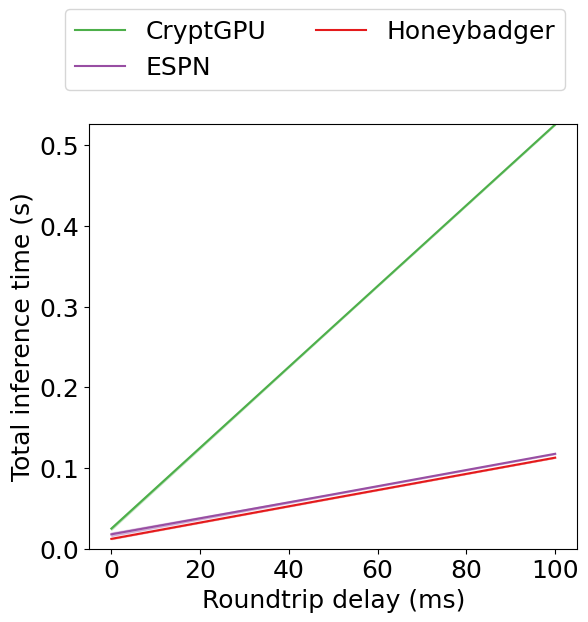

<Figure size 629.921x551.181 with 0 Axes>

In [19]:
for dataset in datasets:
    for model in models[dataset]:
        plot_model(model , reject=['crypten12'], add_device=False)

default12


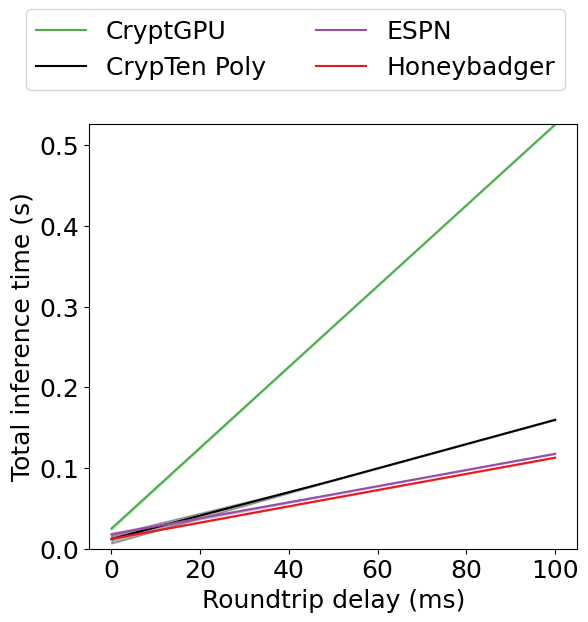

<Figure size 629.921x551.181 with 0 Axes>

In [16]:
for model in models["relus"]:
    plot_model(model , add_device=False)

In [17]:
# model_path = models["relus"][1]
# results = get_all_results(model_path)
# plot_name = "_".join(model_path.split('/')[-2:])
# plot_name = plot_name[:-2] if plot_name[-2:] == ":0" else plot_name
# plot_results(results, f"../plots/relu.pdf",add_device=False, scale_setter="default12")

In [18]:
# results = get_all_results(models['cifar10'][1])+get_all_results(models['cifar10'][2])+[get_all_results(models['cifar10'][5])[1]]
# labels = ["maxpool","gforce_max",  "avgpool", "gforce_avg"]
# color_vals = list(colors.values())
# for i, result in enumerate(results):
#     plot_result(result, color_vals[i], labels[i])
# plt.legend()
# plt.xlabel("Artificial roundtrip delay in ms")
# plt.ylabel("Total inference runtime in seconds")
# plt.savefig("vgg16.png")